In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [31]:
data = pd.read_csv('mnist_train.csv')
data = data.values


In [32]:
labels = data[:, 0]
data = data[:,1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


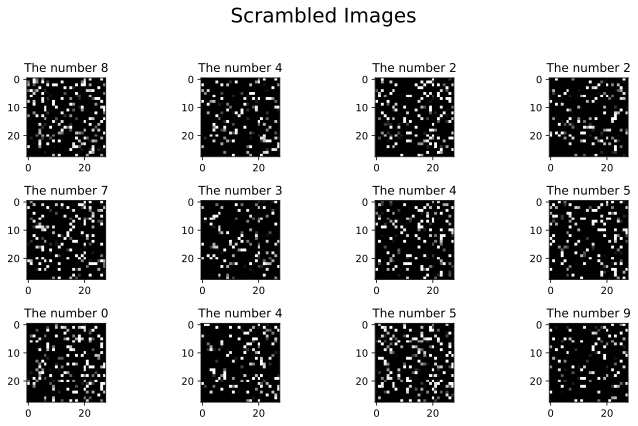

In [33]:
# randomly scrambling the data
eggs = np.random.permutation(data.shape[1])
scrambled = data[:, eggs]

fig, axs = plt.subplots(3,4, figsize = (10,6))

for ax in axs.flatten():

    # pick a random image
    randimg2show = np.random.randint(0, high = data.shape[0])

    # create the image 
    img = np.reshape(scrambled[randimg2show, :], (28,28) )
    ax.imshow(img, cmap = 'gray')

    # title 
    ax.set_title('The number %i' %labels[randimg2show])

plt.suptitle('Scrambled Images', fontsize = 20)
plt.tight_layout(rect = [0,0,1,.95])
plt.show()

In [34]:
# step 1 : convert to tensor 
dataT = torch.tensor(scrambled).float()
labels = torch.tensor(labels).long()

# step 2 : splitting the data 
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size = .1)

# step 3 : convert tensor datasets 
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels) 

# step 4 : dataloaders 
train_loader = DataLoader(train_data, batch_size = 32)
test_loader = DataLoader(test_data, batch_size = len(test_data))

In [26]:
# step 1 : convert to tensor 
dataT = torch.tensor(data).float()
# labels = torch.tensor(labels).long()

# step 2 : splitting the data 
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size = .1)

# # step 3 : convert tensor datasets 
# train_data = TensorDataset(train_data, train_labels)
# test_data = TensorDataset(test_data, test_labels) 

# step 4 : dataloaders 
train_loader = DataLoader(dataT, batch_size = 32)


In [35]:
for i,j in train_loader:
    print(i)

tensor([[  0., 255., 159.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.]])
tensor([[  0.,   0., 253.,  ...,   0.,   0.,   0.],
        [  0.,   0., 163.,  ...,   0.,   0.,   0.],
        [  0., 220.,   0.,  ...,   0., 237.,   0.],
        ...,
        [  0., 127.,   0.,  ...,   0.,   0.,   0.],
        [  0., 245., 161.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0., 252.,   0.]])
tensor([[  0.,   0.,   0.,  ...,   0.,  85.,   0.],
        [  0., 138.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0., 106.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,  47.,   0.],
        [  0.,   0., 210.,  ...,   0.,   0.,   0.]])
tensor([[  0.,   0.,  

In [19]:
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            

            # input layer 
            self.input = nn.Linear(784, 64)

            # hidden layers
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # output layer 
            self.output = nn.Linear(32, 10)

        def forward(self, X):
            
            X = f.relu(self.input(X))
            X = f.relu(self.fc1(X))
            X = f.relu(self.fc2(X))

            return self.output(X)
        
    # create the model instance 
    net = mnistNet()

    # loss function 
    lossfun = nn.CrossEntropyLoss()

    # optimizer 
    optimizer = torch.optim.SGD(net.parameters(), lr = .01)

    return net, lossfun, optimizer 



            
            

In [20]:
def function2trainTheModel():

    # number of epochs 
    numepochs = 100

    # create a new model 
    net, lossfun, optimizer = createTheMNISTNet()

    # losses 
    losses = np.zeros(numepochs)
    trainAcc = []
    testAcc = []


    for epochi in range(numepochs):
        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)
            batchLoss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # matches 
            matches = (torch.argmax(yHat, axis = 1) == y ).float()
            accuracypct = 100*torch.mean(matches)
            batchAcc.append(accuracypct)
        
        losses[epochi] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = net(X)
            loss = lossfun(yHat, y)
            matches = (torch.argmax(yHat, axis = 1) == y ).float()
            accuracypct = 100*torch.mean(matches)
            testAcc.append(accuracypct)

    return trainAcc, testAcc, losses, net


In [21]:
trainAcc, testAcc, losses, net = function2trainTheModel()

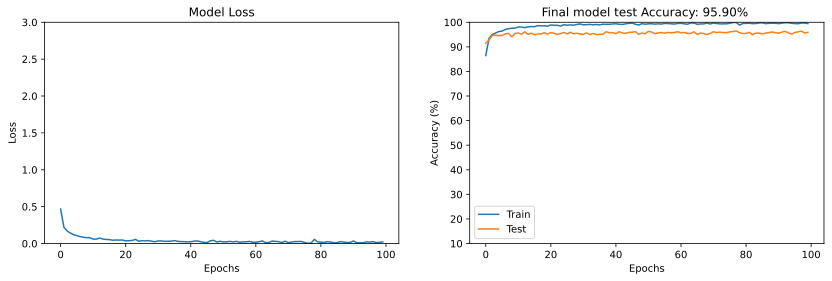

In [22]:
fig, ax = plt.subplots(1,2, figsize = (14,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, label = 'Train')
ax[1].plot(testAcc, label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test Accuracy: {testAcc[-1]:.2f}% ')
ax[1].legend()

plt.show()